In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='time'>

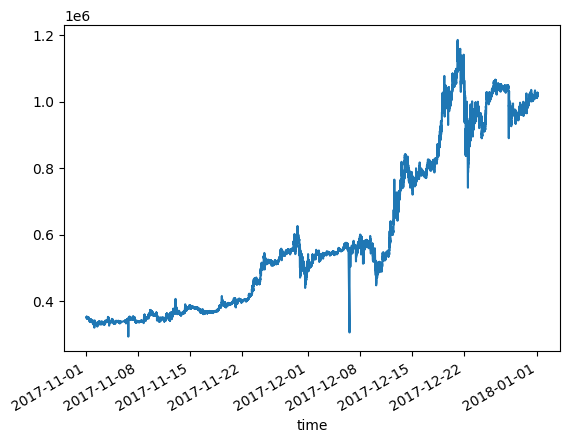

In [34]:
modify_data = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/시계열/fnguide/data/sub_upbit_eth_min_tick.csv', index_col=0, parse_dates=True)
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

# ① Price Change Direction

In [35]:
window = 50
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

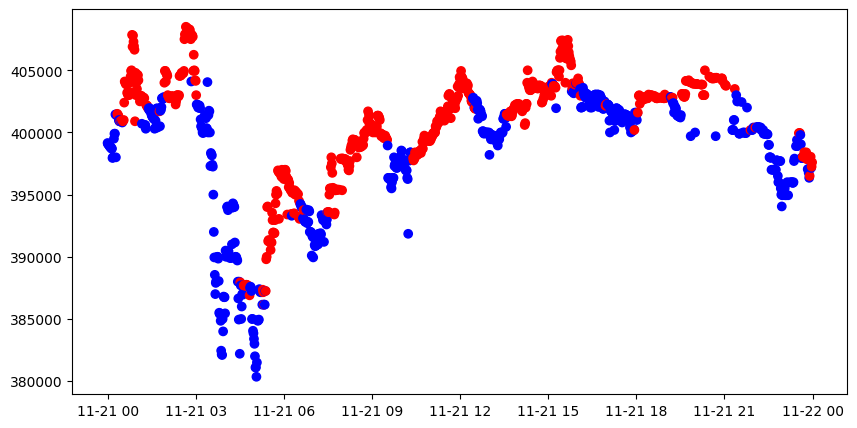

In [36]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

# ② Using Moving Average

In [37]:
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

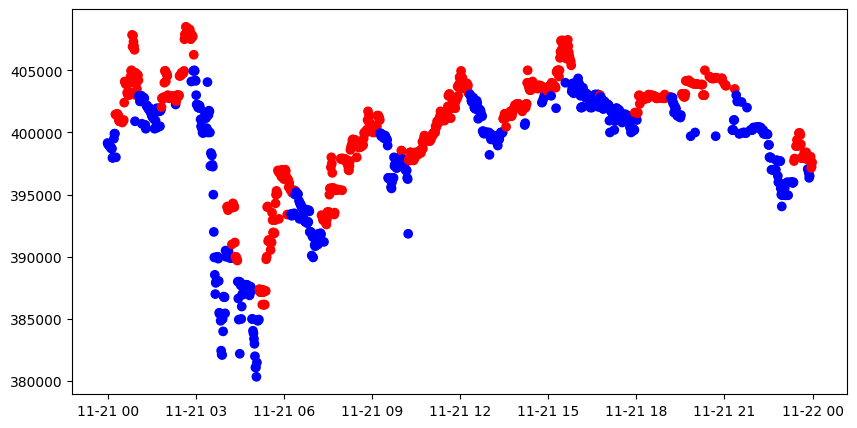

In [38]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

# ③ Local Min-Max

In [39]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [40]:
mins, maxes = get_local_min_max(sub_data, wait=3)
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

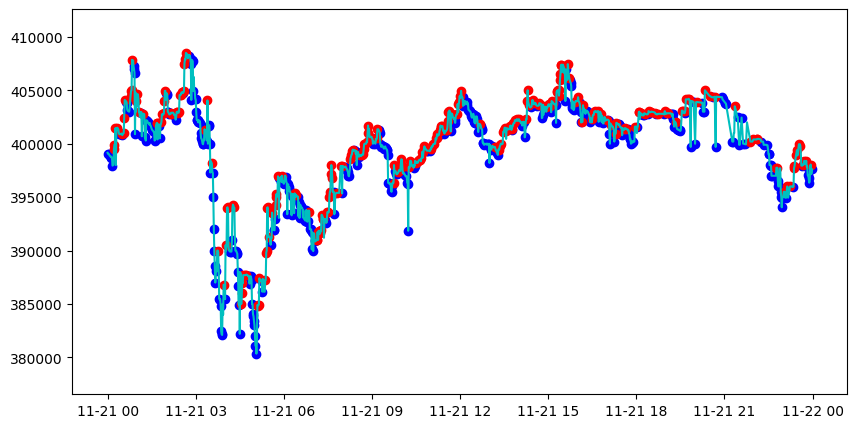

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

# ④ Trend Scanning

In [42]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [43]:
look_forward_window = 50
min_sample_length = 10
step = 1
t1_array = []
t_values_array = []

In [44]:

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0], step):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [04:24<00:00, 126.34it/s]


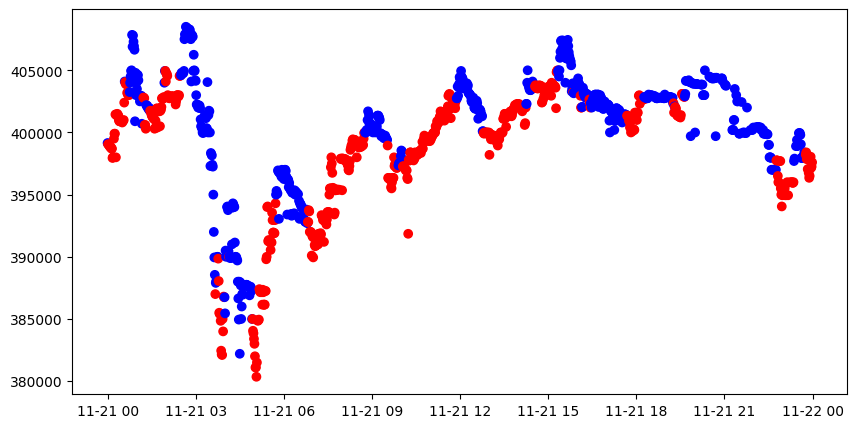

In [45]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])